In [35]:
import math
import numpy
import numpy as np
import torch
from torch import nn, optim

M = 2
d = 1024
n_ = 100
dh = 512
dv = 512
cp = 4
class TF(nn.Module):
    def __init__(self):
        super().__init__()
        self.q = nn.Linear(d, dh, bias=False)
        self.k = nn.Linear(d, dh, bias=False)
        self.v = nn.Linear(d, dv, bias=False)
        self.fc = nn.Linear(dv, 1, bias=False)
        self.fc.requires_grad_(False)
        
        # self.v.weight.data = torch.randn(dv, d)*math.exp(0.5)
        self.v.weight.data = torch.randn(dv, d)*0.5
        self.q.weight.data /= 16
        self.k.weight.data /= 16
        self.v.weight.data /= 16


    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        qk = torch.matmul(q, k.transpose(1, 2))
        attn = qk.softmax(dim=2)
        attn = torch.sum(attn, dim=1).unsqueeze(1)
        attn /= 16
        z = torch.matmul(attn, v).squeeze(1)
        return self.fc(z)

def make_mu1(mu):
    mu1 = numpy.zeros(d)
    mu1[0] = mu
    return mu1

def make_mu2(mu):
    mu2 = numpy.zeros(d)
    mu2[1] = mu
    return mu2

def make_noise(strength):
    # return numpy.random.normal(0, strength, size=d)
    noise =  numpy.random.normal(0, strength, size=d)    
    norm = np.linalg.norm(noise)
    return  noise * (36 / norm)
def get_test_loss(n, mu):
    D = []
    D_Y = []
    D_ = []
    D_Y_ = []

    mu1 = make_mu1(mu)
    mu2 = make_mu2(mu)

    D_mu = []
    D_mu_ = []

    for i in range(int(n / 2)):
        X = mu1.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D.append(X)
        D_Y.append([1.])
        D_mu.append(mu1.reshape(1, d))
        X = mu2.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D.append(X)
        D_Y.append([-1.])
        D_mu.append(mu2.reshape(1, d))

    D = torch.tensor(D, dtype=torch.float32).cuda()
    D_Y = torch.tensor(D_Y).cuda()

    for i in range(int(n_ / 2)):
        X = mu1.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D_.append(X)
        D_Y_.append([1.])
        D_mu_.append(mu1.reshape(1, d))
        X = mu2.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D_.append(X)
        D_Y_.append([-1.])
        D_mu_.append(mu2.reshape(1, d))

    D_ = torch.tensor(D_, dtype=torch.float32).cuda()
    D_Y_ = torch.tensor(D_Y_).cuda()

    model = TF().cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0)
    loss_fn = nn.SoftMarginLoss().cuda()
    EPOCHS = 1000

    test_losses = []
    for epoch in range(1, EPOCHS + 1):
        model.train()
        optimizer.zero_grad()
        output = model(D)

        training_loss = loss_fn(output, D_Y)
        training_loss.backward()
        optimizer.step()

        model.eval()
        output = model(D_)
        test_loss = loss_fn(output, D_Y_)
        # return test_loss
        if epoch%10 == 0:
            test_losses.append(test_loss.item())

    return test_losses   
    
size = 20
matrix = np.zeros((size, 100))
for n in range(size):
    print(n)
    test_losses = get_test_loss(100, 36)
    matrix[n, :] = test_losses
 
np.savetxt('0.5', matrix)





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


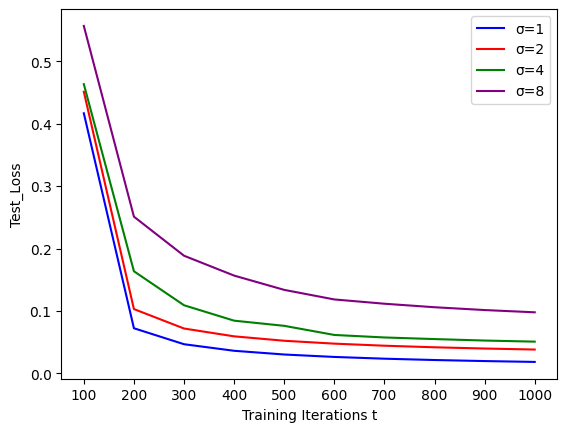

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# 加载npy文件中的矩阵
matrix1 = np.loadtxt('1')
matrix2 = np.loadtxt('2')
matrix3 = np.loadtxt('4')
matrix4 = np.loadtxt('8')  # 假设文件名为 '矩阵4'
# matrix5 = np.loadtxt('0.1')  # 假设文件名为 '矩阵5'
# matrix6 = np.loadtxt('0.01')


# 计算每个矩阵列方向的平均值
mean_matrix1 = np.mean(matrix1, axis=0)
mean_matrix2 = np.mean(matrix2, axis=0)
mean_matrix3 = np.mean(matrix3, axis=0)
mean_matrix4 = np.mean(matrix4, axis=0)
# mean_matrix5 = np.mean(matrix5, axis=0)
# mean_matrix6 = np.mean(matrix6, axis=0)


# 假设要均匀抽出10条数据
num_samples = 10
sample_indices = np.linspace(0, len(mean_matrix1) - 1, num_samples, dtype=int)

# 抽取数据
sampled_matrix1 = mean_matrix1[sample_indices]
sampled_matrix2 = mean_matrix2[sample_indices]
sampled_matrix3 = mean_matrix3[sample_indices]
sampled_matrix4 = mean_matrix4[sample_indices]
# sampled_matrix5 = mean_matrix5[sample_indices]
# sampled_matrix6 = mean_matrix6[sample_indices]


# 生成x轴数据
x = np.arange(num_samples)

# 绘制折线图
plt.plot(x, sampled_matrix1, label='σ=1', color='blue')
plt.plot(x, sampled_matrix2, label='σ=2', color='red')
plt.plot(x, sampled_matrix3, label='σ=4', color='green')
plt.plot(x, sampled_matrix4, label='σ=8', color='purple')  # 添加矩阵4的折线
# plt.plot(x, sampled_matrix5, label='0.1', color='orange')  # 添加矩阵5的折线
# plt.plot(x, sampled_matrix6, label='0.01', color='brown') 


# 添加图例
plt.legend()

# 添加标题和坐标轴标签


plt.xlabel('Training Iterations t')
plt.ylabel('Test_Loss')
plt.xticks(x,[100,200,300,400,500,600,700,800,900,1000])
# 显示折线图

plt.savefig('V.png', dpi=300, bbox_inches='tight')
plt.show()





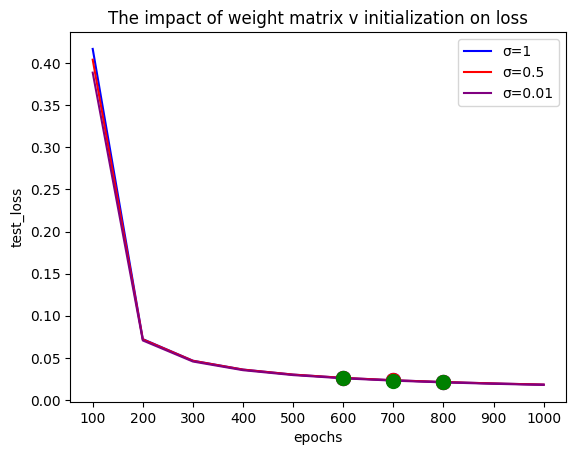

In [40]:

import numpy as np
import matplotlib.pyplot as plt

# 加载npy文件中的矩阵
matrix1 = np.loadtxt('1')
matrix2 = np.loadtxt('0.5')
matrix3 = np.loadtxt('0.1')
matrix4 = np.loadtxt('0.01')  # 假设文件名为 '矩阵4'
# matrix5 = np.loadtxt('0.1')  # 假设文件名为 '矩阵5'
# matrix6 = np.loadtxt('0.01')


# 计算每个矩阵列方向的平均值
mean_matrix1 = np.mean(matrix1, axis=0)
mean_matrix2 = np.mean(matrix2, axis=0)
mean_matrix3 = np.mean(matrix3, axis=0)
mean_matrix4 = np.mean(matrix4, axis=0)
# mean_matrix5 = np.mean(matrix5, axis=0)
# mean_matrix6 = np.mean(matrix6, axis=0)


# 假设要均匀抽出10条数据
num_samples = 10
sample_indices = np.linspace(0, len(mean_matrix1) - 1, num_samples, dtype=int)

# 抽取数据
sampled_matrix1 = mean_matrix1[sample_indices]
sampled_matrix2 = mean_matrix2[sample_indices]
sampled_matrix3 = mean_matrix3[sample_indices]
sampled_matrix4 = mean_matrix4[sample_indices]
# sampled_matrix5 = mean_matrix5[sample_indices]
# sampled_matrix6 = mean_matrix6[sample_indices]


# 生成x轴数据
x = np.arange(num_samples)

# 绘制折线图
plt.plot(x, sampled_matrix1, label='σ=1', color='blue')
plt.plot(x, sampled_matrix2, label='σ=0.5', color='red')
# plt.plot(x, sampled_matrix3, label='σ=0.1', color='green')
plt.plot(x, sampled_matrix4, label='σ=0.01', color='purple')  # 添加矩阵4的折线
# plt.plot(x, sampled_matrix5, label='0.1', color='orange')  # 添加矩阵5的折线
# plt.plot(x, sampled_matrix6, label='0.01', color='brown') 



# 添加图例
plt.legend()

# 添加标题和坐标轴标签

plt.title('The impact of weight matrix v initialization on loss')
plt.xlabel('epochs')
plt.ylabel('test_loss')
plt.xticks(x,[100,200,300,400,500,600,700,800,900,1000])
# 显示折线图
plt.show()

# plt.savefig('不同噪声方差对损失的影响.png', dpi=1200, bbox_inches='tight')



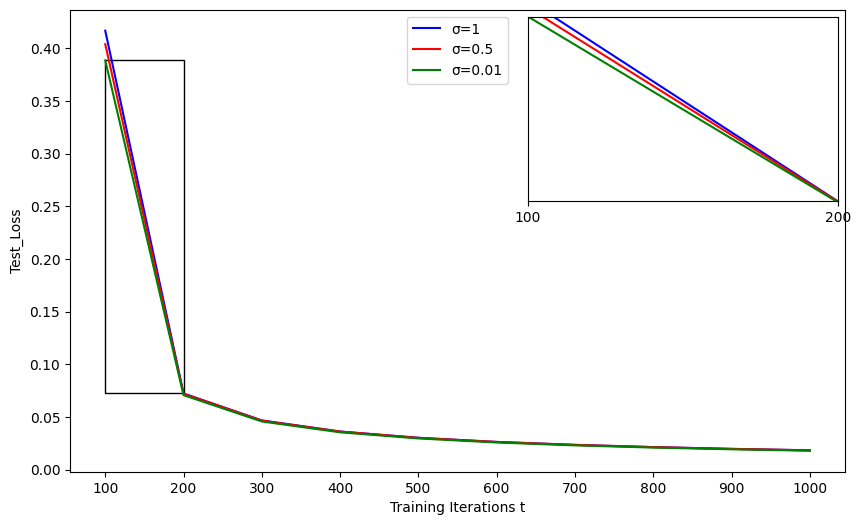

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 加载npy文件中的矩阵
matrix1 = np.loadtxt('1')
matrix2 = np.loadtxt('0.5')
# matrix3 = np.loadtxt('0.1')
matrix4 = np.loadtxt('0.01')  # 假设文件名为 '矩阵4'

# 计算每个矩阵列方向的平均值
mean_matrix1 = np.mean(matrix1, axis=0)
mean_matrix2 = np.mean(matrix2, axis=0)
# mean_matrix3 = np.mean(matrix3, axis=0)
mean_matrix4 = np.mean(matrix4, axis=0)

# 假设要均匀抽出10条数据
num_samples = 10
sample_indices = np.linspace(0, len(mean_matrix1) - 1, num_samples, dtype=int)

# 抽取数据
sampled_matrix1 = mean_matrix1[sample_indices]
sampled_matrix2 = mean_matrix2[sample_indices]
# sampled_matrix3 = mean_matrix3[sample_indices]
sampled_matrix4 = mean_matrix4[sample_indices]

# 生成x轴数据
x = np.arange(num_samples)

# 创建主图
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制主图的折线图
line1, = ax.plot(x, sampled_matrix1, label='σ=1', color='blue')
line2, = ax.plot(x, sampled_matrix2, label='σ=0.5', color='red')
# line3, = ax.plot(x, sampled_matrix3, label='σ=0.1', color='green')
line4, = ax.plot(x, sampled_matrix4, label='σ=0.01', color='green')



# 添加主图的图例、标题和坐标轴标签
ax.legend(handles=[line1, line2, line4], loc='upper center')  # 确保图例在主图中显示

plt.xlabel('Training Iterations t')
plt.ylabel('Test_Loss')
ax.set_xticks(x, [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

# 创建嵌入的小图（放大图）
# 定义嵌入图的位置和大小（左、下、宽、高）
ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper right')

# 定义要放大的区域范围（例如，第3到第7个样本）
inset_start, inset_end = 0, 2
inset_x = x[inset_start:inset_end]

# 在嵌入图中绘制放大区域的曲线
ax_inset.plot(inset_x, sampled_matrix1[inset_start:inset_end], color='blue')
ax_inset.plot(inset_x, sampled_matrix2[inset_start:inset_end], color='red')
# ax_inset.plot(inset_x, sampled_matrix3[inset_start:inset_end], color='green')
ax_inset.plot(inset_x, sampled_matrix4[inset_start:inset_end], color='green')

# 设置嵌入图的范围和刻度
ax_inset.set_xlim(inset_x[0], inset_x[-1])
ax_inset.set_ylim(min(sampled_matrix1[inset_start:inset_end]), max(sampled_matrix4[inset_start:inset_end]))
ax_inset.set_xticks(inset_x,[100,200])
ax_inset.set_yticks([])  # 隐藏Y轴刻度

# 添加矩形框，表示放大区域
rect = plt.Rectangle((inset_x[0], min(sampled_matrix1[inset_start:inset_end])),
                     inset_x[-1] - inset_x[0],
                     max(sampled_matrix4[inset_start:inset_end]) - min(sampled_matrix1[inset_start:inset_end]),
                     edgecolor='black', facecolor='none', linewidth=1)
ax.add_patch(rect)
plt.savefig('_V.png', dpi=450, bbox_inches='tight')
# 显示主图和嵌入图
plt.show()